## Importing modules

In [58]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import kstest
from scipy.stats import gamma
%matplotlib inline

# Basic model setup

In [67]:
# Parameters
p = 5
beta_true = np.array([1, 0.5, -0.5, 0.3, -0.2])
num_simulations = 1000


## Error distributions

In [19]:
# Gamma-distributed errors (centered)
shape, scale = 1.0, 2.0
mean_epsilon = shape * scale

def generate_epsilon(n):
    return gamma.rvs(a=shape, scale=scale, size=n) - mean_epsilon

## Simulation Function

In [21]:
def simulate_LPQ(n, num_simulations = 10000):
    # Design matrix (fixed across simulations)
    X = np.hstack([np.ones((n, 1)), np.random.normal(size=(n, p-1))])
    XtX_inv = np.linalg.inv(X.T @ X)

    # Storage for LPQ estimates
    beta_lpq_estimates = np.zeros((num_simulations, p))

    for i in tqdm(range(num_simulations), desc="Simulating LPQ estimates"):
        # Generate data
        epsilon = generate_epsilon(n)
        y = X @ beta_true + epsilon

        # OLS estimate and residuals
        beta_ols = XtX_inv @ X.T @ y
        z = y - X @ beta_ols

        # Moment estimates
        sigma_hat = np.sqrt(np.mean(z**2))
        m3 = np.mean((z - np.mean(z))**3) / sigma_hat**3
        m4 = np.mean((z - np.mean(z))**4) / sigma_hat**4
        gamma_vec = np.full(n, m4 - 3)
        mu_vec = np.full(n, m3)

        # Residual projection matrix
        M = np.eye(n) - X @ XtX_inv @ X.T
        M_squared = M * M  # Hadamard square

        # LPQ estimation
        beta_lpq = np.zeros(p)
        for j in range(p):
            b_j = XtX_inv[j, :] @ X.T  # shape (n,)
            A = 2 * M_squared + np.diag(gamma_vec)
            c = 3 * (b_j * mu_vec)
            h_j = -0.5 * np.linalg.solve(A, c)
            H_j = M @ np.diag(h_j) @ M

            quad_term = (1 / sigma_hat) * y.T @ H_j @ y
            trace_term = sigma_hat * np.trace(H_j)
            beta_lpq[j] = b_j @ y + quad_term - trace_term

        beta_lpq_estimates[i] = beta_lpq
    return beta_lpq_estimates

Now we will conduct the simulation for n = 100, 200, 500, 1000 points

In [22]:
def analyse(n):
    beta_pred = simulate_LPQ(n)
    for i in range(p):
        print(f"β_{i+1}: ", np.mean(beta_pred[:, i]))

    plt.hist(beta_pred[:,0], bins=50)
    plt.show()

    for j in range(p):
        samples = beta_pred[:, j]
        mu_hat = np.mean(samples)
        std_hat = np.std(samples, ddof=1)
        stat, p_val = kstest(samples, 'norm', args=(mu_hat, std_hat))
        print(f"β_{j+1}: KS statistic = {stat:.4f}, p = {p_val:.4f}")
        if p_val < 0.05:
            print("Reject normality (p < 0.05)")
        else:
            print("Cannot reject normality (p >= 0.05)")


Simulating LPQ estimates: 100%|██████████| 10000/10000 [00:15<00:00, 638.36it/s]


β_1:  0.9523322560325381
β_2:  0.5021603755397801
β_3:  -0.49932928878683636
β_4:  0.2994703905609877
β_5:  -0.19980219665348264


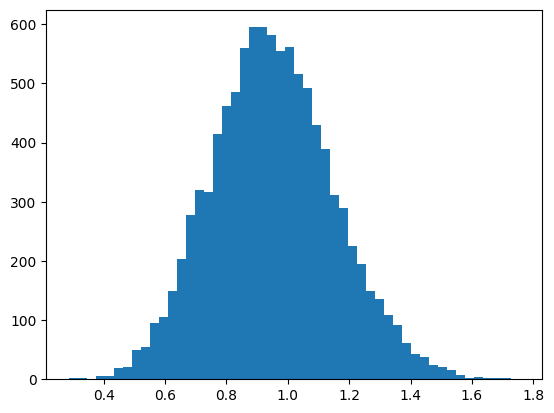

β_1: KS statistic = 0.0153, p = 0.0179
Reject normality (p < 0.05)
β_2: KS statistic = 0.0082, p = 0.5076
Cannot reject normality (p >= 0.05)
β_3: KS statistic = 0.0058, p = 0.8851
Cannot reject normality (p >= 0.05)
β_4: KS statistic = 0.0084, p = 0.4833
Cannot reject normality (p >= 0.05)
β_5: KS statistic = 0.0071, p = 0.6860
Cannot reject normality (p >= 0.05)


In [23]:
analyse(100)

Simulating LPQ estimates: 100%|██████████| 10000/10000 [03:56<00:00, 42.22it/s]


β_1:  0.9822048277670227
β_2:  0.4998135689927687
β_3:  -0.5006324630570852
β_4:  0.3001749442116068
β_5:  -0.199758988514362


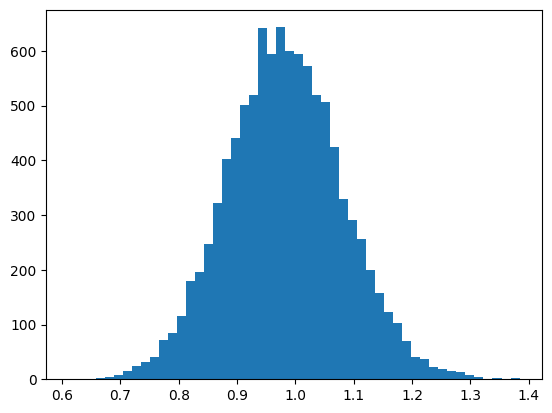

β_1: KS statistic = 0.0086, p = 0.4527
Cannot reject normality (p >= 0.05)
β_2: KS statistic = 0.0064, p = 0.8120
Cannot reject normality (p >= 0.05)
β_3: KS statistic = 0.0065, p = 0.7916
Cannot reject normality (p >= 0.05)
β_4: KS statistic = 0.0035, p = 0.9997
Cannot reject normality (p >= 0.05)
β_5: KS statistic = 0.0065, p = 0.7898
Cannot reject normality (p >= 0.05)


In [11]:
analyse(200)

Simulating LPQ estimates: 100%|██████████| 10000/10000 [13:53<00:00, 12.00it/s] 


β_1:  0.9943309450256691
β_2:  0.5014957803148217
β_3:  -0.5003163133857187
β_4:  0.299852528297462
β_5:  -0.20070938833004126


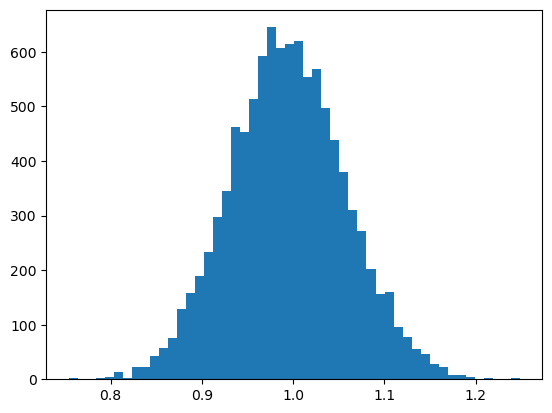

β_1: KS statistic = 0.0073, p = 0.6621
Cannot reject normality (p >= 0.05)
β_2: KS statistic = 0.0075, p = 0.6287
Cannot reject normality (p >= 0.05)
β_3: KS statistic = 0.0073, p = 0.6575
Cannot reject normality (p >= 0.05)
β_4: KS statistic = 0.0067, p = 0.7546
Cannot reject normality (p >= 0.05)
β_5: KS statistic = 0.0063, p = 0.8214
Cannot reject normality (p >= 0.05)


In [ ]:
analyse(500)

## Size and Power of Test

In [62]:
# ------------------------------------------------------------
# 1. Core LPQ Simulation Function (batched)
# ------------------------------------------------------------
def simulate_LPQ_batches(n, p, beta_true, generate_epsilon,
                         num_batches=100, batch_size=200):
    """
    Simulate batches of LPQ estimates for beta_0, ..., beta_{p-1}.
    Returns an array of shape (num_batches, batch_size, p).

    Parameters:
    - n: sample size
    - p: number of regression parameters (including intercept)
    - beta_true: array of length p, true regression coefficients
    - generate_epsilon: function eps = generate_epsilon(n)
       that returns a length-n error vector
    - num_batches: how many independent batches to simulate
    - batch_size: how many LPQ estimates per batch
    """
    # 1a. Build a fixed design matrix X with an intercept + (p-1) normals
    X = np.hstack([
        np.ones((n, 1)),
        np.random.normal(size=(n, p - 1))
    ])
    XtX_inv = np.linalg.inv(X.T @ X)
    M = np.eye(n) - X @ XtX_inv @ X.T
    M_squared = M * M  # Hadamard square, used to build A = 2*(M∘M) + diag(gamma)

    all_batches = np.zeros((num_batches, batch_size, p))

    for b in tqdm(range(num_batches), desc=f"Simulating {num_batches} batches (n={n})"):
        batch = np.zeros((batch_size, p))

        for s in range(batch_size):
            eps = generate_epsilon(n)                  # draw errors of length n
            y = X @ beta_true + eps

            beta_ols = XtX_inv @ (X.T @ y)             # OLS estimate (p,)
            z = y - X @ beta_ols

            sigma_hat = np.sqrt(np.mean(z**2))

            # Estimate skewness and excess kurtosis from residuals
            m3 = np.mean((z - np.mean(z))**3) / sigma_hat**3
            m4 = np.mean((z - np.mean(z))**4) / sigma_hat**4
            gamma_vec = np.full(n, m4 - 3)              # γ_j = m4_j - 3 (identical for all j)
            mu_vec = np.full(n, m3)                     # m3_j (identical)

            beta_lpq = np.zeros(p)

            # Compute each component j = 0,...,p-1
            for j in range(p):
                # b_j = row j of (X'X)^{-1} X'
                b_j = XtX_inv[j, :] @ X.T               # shape (n,)

                # Build A = 2*(M∘M) + diag(gamma_vec)
                A = 2 * M_squared + np.diag(gamma_vec)
                # Build c = 3 * (b_j ∘ mu_vec)
                c = 3 * (b_j * mu_vec)

                # Solve for h_j = -0.5 * A^{-1} c
                h_j = -0.5 * np.linalg.solve(A, c)

                # Build H_j = M diag(h_j) M
                H_j = M @ np.diag(h_j) @ M

                # Compute quadratic term and trace term
                quad_term = (1.0 / sigma_hat) * (y.T @ H_j @ y)
                trace_term = sigma_hat * np.trace(H_j)

                # LPQ estimate for component j
                beta_lpq[j] = b_j @ y + quad_term - trace_term

            batch[s, :] = beta_lpq

        all_batches[b] = batch

    return all_batches

In [68]:
# ------------------------------------------------------------
# 2. Error Generators
# ------------------------------------------------------------
def eps_normal(n):
    """Mean-zero Gaussian errors of length n."""
    return np.random.normal(loc=0.0, scale=1.0, size=n)

def eps_gamma(n):
    raw = np.random.gamma(shape=shape, scale=scale, size=n)
    return raw - shape*scale

In [66]:
# ------------------------------------------------------------
# 3. Estimate Size (Type I Error) under True Normal Errors
# ------------------------------------------------------------
def estimate_size_lpq(n, p, beta_true, num_batches=100, batch_size=200, alpha=0.05):
    """
    Empirically estimate the size of the KS normality test on LPQ beta_0
    when errors are truly normal.
    Returns: empirical_size (float).
    """
    # Simulate LPQ batches using normal errors
    beta_batches = simulate_LPQ_batches(n, p, beta_true, eps_normal, num_batches, batch_size)

    pvals = []
    for batch in beta_batches:
        b0 = batch[:, 1]                      # all batch_size draws of LPQ beta_0
        mu_hat = np.mean(b0)
        std_hat = np.std(b0, ddof=1)
        _, pval = kstest(b0, 'norm', args=(mu_hat, std_hat))
        pvals.append(pval)

    pvals = np.array(pvals)
    empirical_size = np.mean(pvals < alpha)
    return empirical_size


# ------------------------------------------------------------
# 4. Estimate Power under Gamma Errors
# ------------------------------------------------------------
def estimate_power_lpq(n, p, beta_true, num_batches=100, batch_size=200, alpha=0.05):
    """
    Empirically estimate the power of the KS normality test on LPQ beta_0
    when errors are non-normal (Gamma).
    Returns: empirical_power (float).
    """
    # Simulate LPQ batches using Gamma errors
    beta_batches = simulate_LPQ_batches(n, p, beta_true,eps_gamma,num_batches,batch_size)
    pvals = []
    for batch in beta_batches:
        b0 = batch[:, 1]
        mu_hat = np.mean(b0)
        std_hat = np.std(b0, ddof=1)
        if std_hat == 0:
            continue
        _, pval = kstest(b0, 'norm', args=(mu_hat, std_hat))
        pvals.append(pval)

    pvals = np.array(pvals)
    empirical_power = np.mean(pvals < alpha)
    return empirical_power

Simulating 200 batches (n=10): 100%|██████████| 200/200 [00:12<00:00, 16.23it/s]


n= 10 | Size ≈ 1.000 | Power ≈ 1.000


Simulating 200 batches (n=20): 100%|██████████| 200/200 [00:14<00:00, 14.10it/s]


n= 20 | Size ≈ 1.000 | Power ≈ 1.000


Simulating 200 batches (n=30): 100%|██████████| 200/200 [00:15<00:00, 13.28it/s]


n= 30 | Size ≈ 0.975 | Power ≈ 0.980


Simulating 200 batches (n=40): 100%|██████████| 200/200 [00:17<00:00, 11.76it/s]


n= 40 | Size ≈ 0.385 | Power ≈ 0.670


Simulating 200 batches (n=50): 100%|██████████| 200/200 [00:19<00:00, 10.19it/s]


n= 50 | Size ≈ 0.005 | Power ≈ 0.180


Simulating 200 batches (n=60): 100%|██████████| 200/200 [00:24<00:00,  8.33it/s]


n= 60 | Size ≈ 0.010 | Power ≈ 0.000


Simulating 200 batches (n=70): 100%|██████████| 200/200 [00:28<00:00,  6.91it/s]


n= 70 | Size ≈ 0.000 | Power ≈ 0.000


Simulating 200 batches (n=80): 100%|██████████| 200/200 [00:34<00:00,  5.74it/s]


n= 80 | Size ≈ 0.000 | Power ≈ 0.000


Simulating 200 batches (n=90): 100%|██████████| 200/200 [00:43<00:00,  4.59it/s]


n= 90 | Size ≈ 0.000 | Power ≈ 0.000


Simulating 200 batches (n=100): 100%|██████████| 200/200 [00:55<00:00,  3.63it/s]


n=100 | Size ≈ 0.000 | Power ≈ 0.000


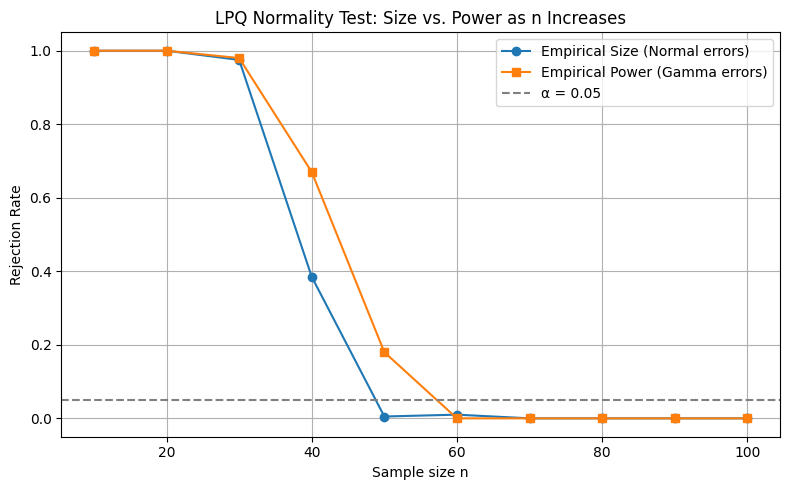

In [70]:
# Simulation settings
batch_size = 200
num_batches = 200
alpha = 0.05

ns = list(range(10, 101, 10))  # n = 50, 100, 150, ..., 500
sizes = []
powers = []

for n in ns:
    # 5a. Empirical size (Normal errors)
    size_n = estimate_size_lpq(
        n=n,
        p=p,
        beta_true=beta_true,
        num_batches=num_batches,
        batch_size=batch_size,
        alpha=alpha
    )
    sizes.append(size_n)

    # 5b. Empirical power (Gamma errors)
    power_n = estimate_power_lpq(
        n=n,
        p=p,
        beta_true=beta_true,
        num_batches=num_batches,
        batch_size=batch_size,
        alpha=alpha
    )
    powers.append(power_n)

    print(f"n={n:3d} | Size ≈ {size_n:.3f} | Power ≈ {power_n:.3f}")

# 6. Plot Size and Power vs. n
plt.figure(figsize=(8, 5))
plt.plot(ns, sizes, marker='o', label="Empirical Size (Normal errors)")
plt.plot(ns, powers, marker='s', label="Empirical Power (Gamma errors)")
plt.axhline(alpha, color='gray', linestyle='--', label=f"α = {alpha}")
plt.xlabel("Sample size n")
plt.ylabel("Rejection Rate")
plt.title("LPQ Normality Test: Size vs. Power as n Increases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()